In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/fasttext-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar/fasttext')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar/fasttext/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/fasttext-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0908 15:22:48.271408  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 15:22:48.471876  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 15:23:19.329675  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 15:23:19.557940  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0908 15:23:19.561794  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0908 15:30:00.509170  1768 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 15:30:00.600145  1768 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1728150 samples, validate on 216019 samples
Epoch 1/10
1728150/1728150 [==============================] - 264s 153us/step - loss: 0.3138 - acc: 0.9360 - val_loss: 0.0583 - val_acc: 0.9901
Epoch 2/10
1728150/1728150 [==============================] - 253s 146us/step - loss: 0.0527 - acc: 0.9901 - val_loss: 0.0479 - val_acc: 0.9901
Epoch 3/10
1728150/1728150 [==============================] - 262s 152us/step - loss: 0.0422 - acc: 0.9901 - val_loss: 0.0346 - val_acc: 0.9901
Epoch 4/10
1728150/1728150 [==============================] - 267s 154us/step - loss: 0.0258 - acc: 0.9917 - val_loss: 0.0194 - val_acc: 0.9931
Epoch 5/10
1728150/1728150 [==============================] - 206s 119us/step - loss: 0.0159 - acc: 0.9944 - val_loss: 0.0128 - val_acc: 0.9963
Epoch 6/10
1728150/1728150 [==============================] - 210s 122us/step - loss: 0.0110 - acc: 0.9972 - val_loss: 0.0095 - val_acc: 0.9975
Epoch 7/10
1728150/1728150 [==============================] - 211s 122us/step - los

# Learning curves

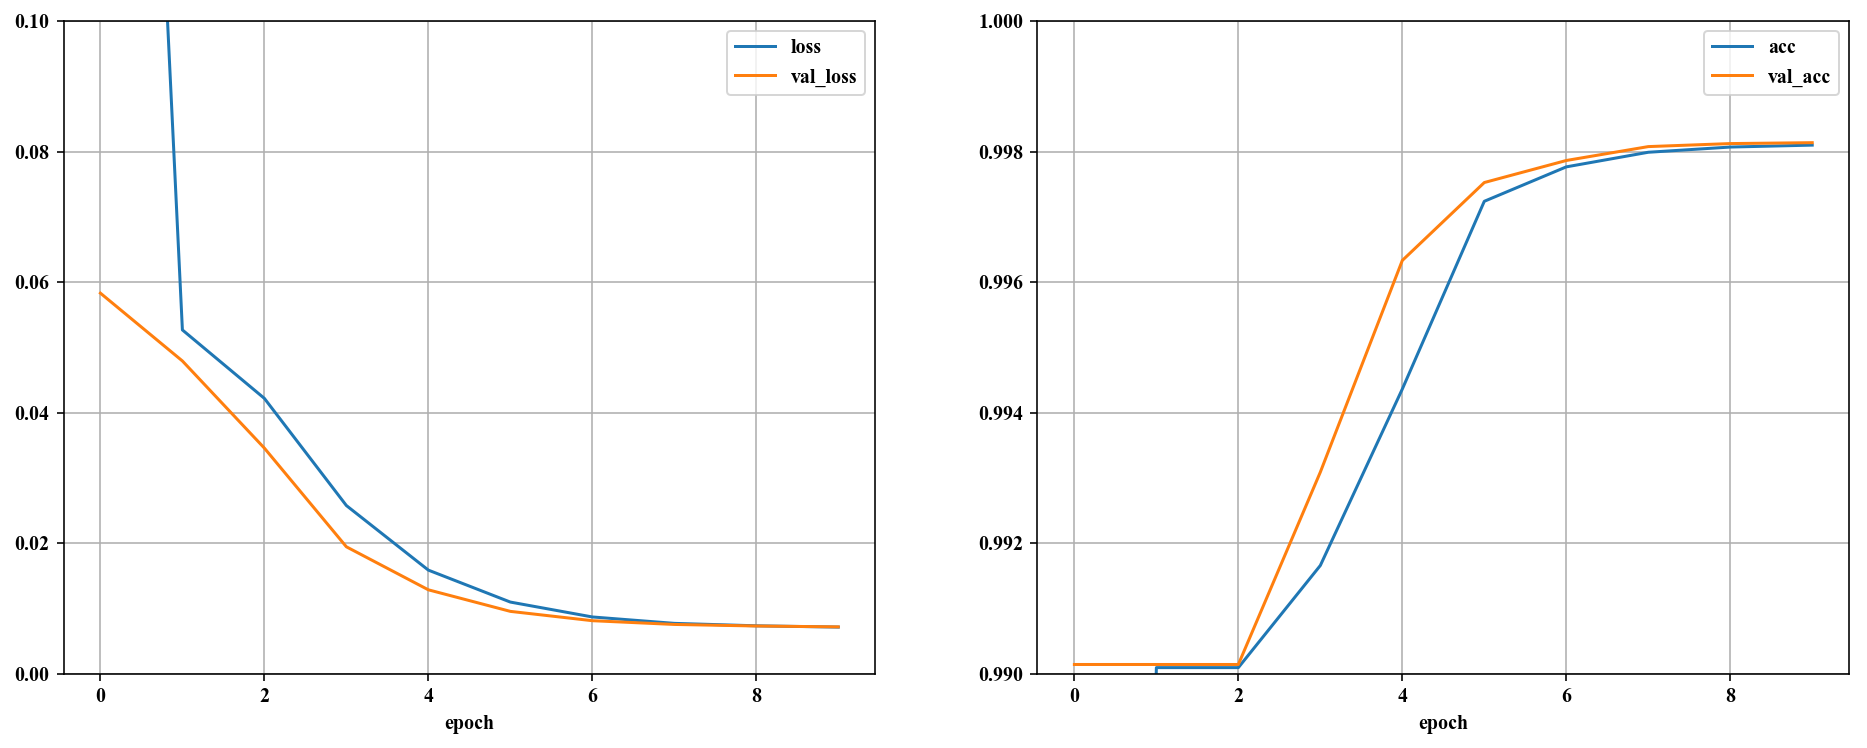

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.1)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213889
           1       0.97      0.84      0.90      2130

   micro avg       1.00      1.00      1.00    216019
   macro avg       0.98      0.92      0.95    216019
weighted avg       1.00      1.00      1.00    216019

[[213837     52]
 [   350   1780]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
108258,conf/sigmod/LiuPTBBZBHY98,CQ : A Personalized Update Monitoring Toolkit,"L Liu , C Pu , W Tang , D Buttler , J Biggs , T Zhou , P Benninghoff , W Han , F Yu",SIGMOD Conference,1998,0e3PPUvtZ0MJ,A personalized update monitoring toolkit,", J Biggs , T Zhou , P Benninghoff , W Han , FY CQ",Haas and Tiwary,0.0
165325,journals/sigmod/DAndreaJ96,<unk> 's Next-Generation Object-Relational Database Management System,"A <unk> , P Janus",SIGMOD Record,1996,-XugBF7u07EJ,<unk> ? ? s nextgeneration object-relational database management system,", P Janus","ACM SIGMOD Record ,",1996.0
166889,conf/vldb/ScheuermannSV96,WATCHMAN : A Data Warehouse Intelligent Cache Manager,"P Scheuermann , J Shim , R <unk>",VLDB,1996,EnrllAo58CMJ,"J : Shim , and R. <unk> WATCHMAN : A data warehouse intelligent cache manager",P Scheuermann,<unk>,0.0
105181,journals/sigmod/BoscMP01,Report on The fourth International Conference on Flexible Query Answering systems,<unk>,<unk>,2001,url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D959085%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222,Report on <unk> 2002 : Fifth International Conference on Flexible Query Answering Systems,"A Motro , T Andreasen","SIGMOD Record ,",2003.0
47434,conf/vldb/AgrawalS94,Fast Algorithms for Mining Association Rules in Large Databases,"R Agrawal , R Srikant",VLDB,1994,cIJQ0qxrkMIJ,Fast algorithms for mining association rules in large databases,"RA <unk> , R Srikant","Proceedings of International Conference on Very Large … ,",0.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-fasttext.csv', index=False)
model.save_weights('../data/models/dblp-scholar-fasttext-base-1-num-null')

# Test model 

In [9]:
model.load_weights('../data/models/dblp-scholar-fasttext-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99823   0.99978   0.99900    213884
           1    0.97338   0.82201   0.89132      2135

   micro avg    0.99802   0.99802   0.99802    216019
   macro avg    0.98580   0.91089   0.94516    216019
weighted avg    0.99798   0.99802   0.99794    216019

[[213836     48]
 [   380   1755]]
